In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [3]:
import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np

dl = DataLib("SignalData")

# Bond Returns

Going to start by looking at log and diff methods of rolling returns.

One thing I am not clear on logically how do we want to look at bond returns?

Depends on how we are analyzing them. 

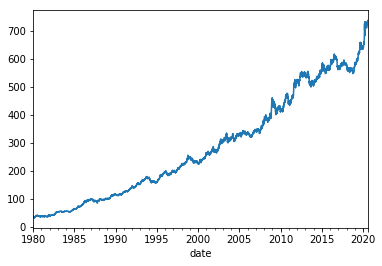

In [17]:
BondIndex = dl.pull('BondRetIdx/LocalFX')
BondIndex['USA'].plot()

date
2020-07-28    0.002666
2020-07-29    0.000016
2020-07-30    0.003746
2020-07-31    0.000516
2020-08-03   -0.002460
Freq: B, Name: USA, dtype: float64

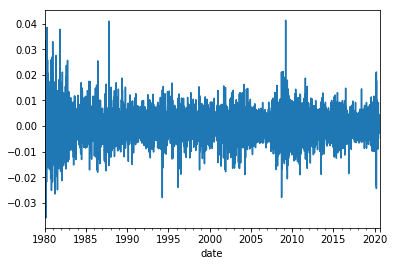

In [18]:
BondIndex['USA'].pct_change().plot()
BondIndex['USA'].pct_change().tail()

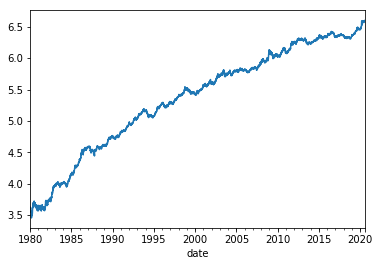

In [19]:
# Log bond returns 
import math 

np.log(BondIndex['USA']).plot()

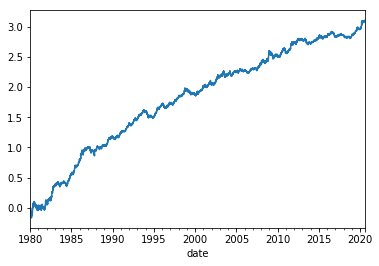

In [20]:
# Why is it not different to this?

BondIndex['USA'].pct_change().cumsum().plot()

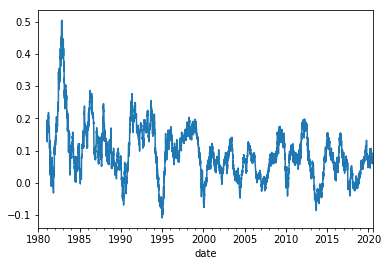

In [21]:
# Method 1 daily changes accumulated over rolling window for bond returns 

WEEKDAYS_IN_YEAR = 261
WEEKDAYS_QUARTER = round(WEEKDAYS_IN_YEAR/4)

BondReturnMethod1 = BondIndex['GBR'].pct_change().rolling(WEEKDAYS_IN_YEAR).sum()

BondReturnMethod1.plot()

# Here we are taking the bond index and seeing it's daily changes. We are then 
# accumulating these yearly changes through a sum. 

# What does this show us?
    # Sum of the percent changes over the window of a year 

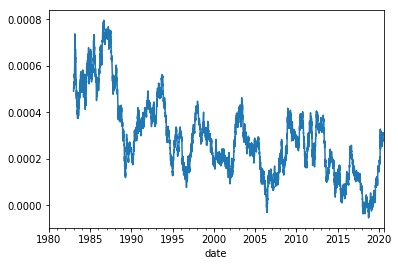

In [22]:
# Method 2 daily changes over rolling window for bond returns 


BondReturnMethod2 = BondIndex['USA'].pct_change().rolling(3*WEEKDAYS_IN_YEAR).mean()

BondReturnMethod2.plot()

# Here we are taking the bond index and seeing it's daily changes. We are then taking a monthly average of these
# daily changes. This doesn't seem very helpful. 

# What does this show us?
    # Mean of percent changes over the window of a year 

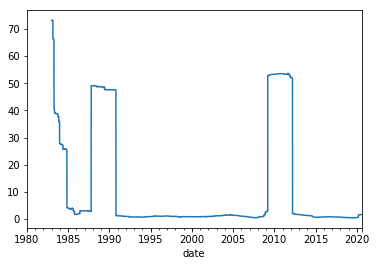

In [23]:
# Annualizing bond returns here it makes sense because these are the major crashes when bonds produced the
# most returns 

BondReturnUnannualized = BondIndex['USA'].pct_change()
BondReturnAnnualized = (BondReturnUnannualized + 1) ** 261 - 1

BondReturnRolling = BondReturnAnnualized.rolling(261*3).mean() 
BondReturnRolling.plot()

# FX Appreciation Exploration

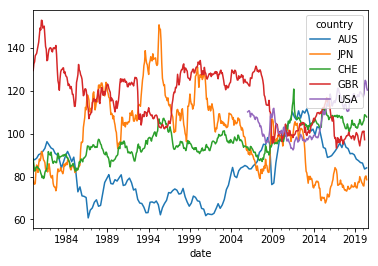

In [24]:
# Originally started by looking at the trade weighted index 
# Importance of a country's trade with other countries 

realFX = dl.pull("fxTrdWts/Real")
realFX.plot()

In [25]:
realFX.tail()

country,AUS,JPN,CHE,GBR,USA
date,,,,,
2020-04,83.690,79.951,108.640,NaN,124.912
2020-05,83.873,80.281,108.268,NaN,124.278
2020-06,84.056,78.531,107.813,NaN,121.456
2020-07,NaN,NaN,NaN,NaN,120.370
2020-08,NaN,NaN,NaN,NaN,NaN


In [26]:
realFXAppr = realFX.resample('Y').last().pct_change()
realFXAppr.tail()

country,AUS,JPN,CHE,GBR,USA
date,,,,,
2016,0.051267,0.065244,-0.000297,-0.142484,0.045784
2017,-0.001364,-0.033456,-0.049469,0.004261,-0.063941
2018,-0.037658,0.028618,0.023900,-0.014739,0.045016
2019,-0.043135,0.015103,-0.001843,0.041292,-0.005465
2020,-0.025652,0.024928,0.031595,-0.038319,0.020682


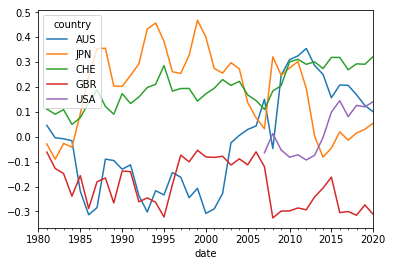

In [27]:
realFXAppr.cumsum().plot()

# Realized that this doesn't provide the clearest illustration of currency appreciation (think Big Max Index)

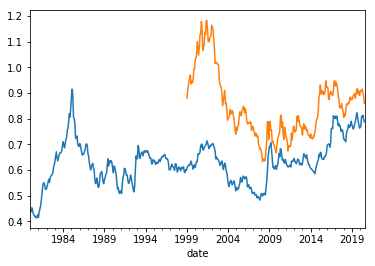

In [28]:
# Looking at foreign nominal exchange rates to gain a better picture 
# Will look at GBR 

fxVsUSD = dl.pull("fxVsUSD")

# Accounting for flips in exchange rates (originally thought this was the way to go about it)
SterlingExchange = 1/fxVsUSD["GBR"]
EuroExchange = 1/fxVsUSD["USA"]

SterlingExchange.plot()
EuroExchange.plot()


## Sterling Appreciation vs Nominal Bond Yields

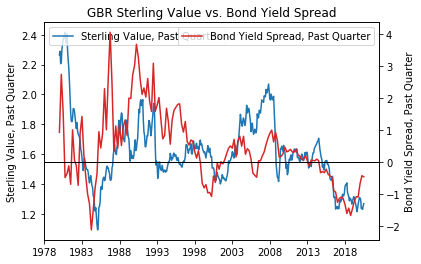

In [48]:
SterlingAppreciationQuarter = SterlingExchange
LongRatesQuarterYields = LongRates.resample('Q').last()#.pct_change()
DiffGBRUSA = LongRatesQuarterYields['GBR'] - LongRatesQuarterYields['USA']
# Difference in interest rates is another way of doing percent change (comparing from the same benchmark)
# aka yield spread
# When the yield spread rises, so does currency value


# FX Appreciation is an excellent predictor of bond yields 
# Here we have to be aware that bond yields don't take inflation into account
# But important to note that lower inflation and lower rates will come with currency appreciation 

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Sterling Value, Past Quarter'
ax1.plot(fxVsUSD['GBR'].to_timestamp(), color = 'tab:blue', label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend(loc=2)
ax2_label = 'Bond Yield Spread, Past Quarter'
ax2.plot(DiffGBRUSA.to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
ax2.axhline(linewidth=1, color='black')
plt.title('GBR Sterling Value vs. Bond Yield Spread')
plt.show()

# Maybe steepness of the curve can be combined
# LongMinusShortRatesQuarter = LongMinusShortRates.resample('Y').last().pct_change()

Negative relationship between appreciation and and bond yields. 
Positive relationship between appreciation and and bond yield spreads. 

If the bond spread between two countries widens: 
The currency of the country with the higher bond yield appreciates against the other currency of the country with the lower bond yield. 

Would want to long bonds in the appreciating currency country or short in the depreciating currency country. 

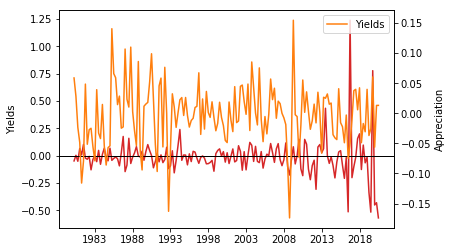

In [49]:
SterlingAppreciationQuarter = fxVsUSD['GBR'].resample('Q').last().pct_change()
LongRatesQuarterYields = LongRates['GBR'].resample('Q').last().pct_change()
Diff = SterlingAppreciationQuarter-LongRatesQuarterYields

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Yields'
#ax1.plot(Diff.to_timestamp(), color = 'tab:blue', label = ax1_label)
ax1.plot(LongRatesQuarterYields.to_timestamp(), color = 'tab:red', label = ax1_label)
ax1.set_ylabel(ax1_label)
ax2_label = 'Appreciation'
ax2.plot(SterlingAppreciationQuarter.to_timestamp(), color = 'tab:orange', label = ax1_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
ax1.axhline(linewidth=1, color='black')
plt.show()


# Here we see negative relationship between bond yields and sterling appreciation 
# What happened around 2008?
    # Pound deppreciated and bond prices went up at the same time because of the crisis 
    # Different story to our usual one people are buying bonds for fear of future and pound is crashing regardless
    # UK gov't trying to prop up the country through QE, devaluing the pound 

In [50]:
# Naive of how the indicator could work arbitrarily 
# JUST FOR MENTAL IMAGE -- doesn't make sense as actual indicator because not scaled!
BondReturnIndex = dl.pull('BondRetIdx/LocalFX')
BondChange = BondReturnIndex.pct_change()

AdjustedSterlingAppreciationQuarter = SterlingAppreciationQuarter*100000

Position = AdjustedSterlingAppreciationQuarter[-1]*BondChange['GBR'].iloc[-1]*100


print("Position is:", round(Position,2),"%")


Position is: 13.78 %


## Sterling Appreciation vs Bond Returns 

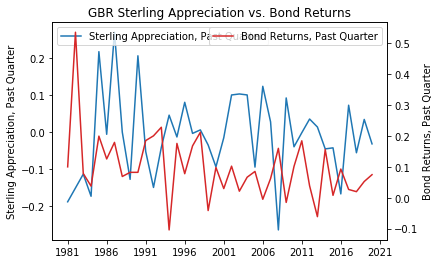

In [51]:
# Bond returns should go up with sterling appreciation 

SterlingAppreciationQuarter = fxVsUSD['GBR'].resample('Y').last().pct_change()
BondReturnsPastQuarter = BondReturnIndex.resample('Y').last().pct_change()


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Sterling Appreciation, Past Quarter'
ax1.plot(SterlingAppreciationQuarter.to_timestamp(), color = 'tab:blue', label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend(loc=2)
ax2_label = 'Bond Returns, Past Quarter'
ax2.plot(BondReturnsPastQuarter['GBR'].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title('GBR Sterling Appreciation vs. Bond Returns')
plt.show()

# Bond Premium

In [52]:
LongRates = dl.pull('LongRates')
ShortRates = dl.pull('ShortRates')

In [53]:
# Here we calculate the bond premium 
LongMinusShortRates = LongRates - ShortRates
dl.write_data("LongMinusShortRates", LongMinusShortRates)
LongMinusShortRates.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,0.472,0.183,0.220,0.845,0.528,1.135,0.141,0.235,0.197,0.401
2020-05,0.668,0.173,0.195,0.838,0.501,1.252,0.132,0.108,0.213,0.438
2020-06,0.619,0.260,0.250,0.988,0.486,1.126,0.170,0.214,0.233,0.504
2020-07,0.660,0.260,0.241,1.000,0.534,1.236,0.186,0.255,0.274,0.518
2020-08,0.583,0.177,0.205,0.713,0.415,1.097,0.158,0.260,0.174,0.448


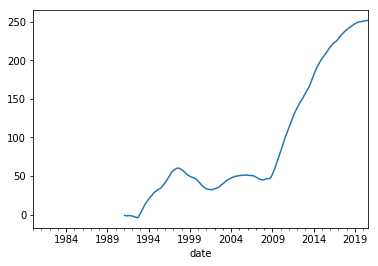

In [54]:
# Cumulative sum of bond premium (in places it rose more steeply economy was probably expanding - long rates
# much greater than short rates)
LongMinusShortRates['GBR'].cumsum().plot()

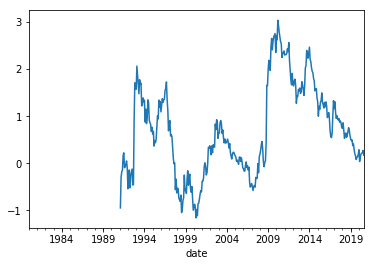

In [55]:
LongMinusShortRates['GBR'].plot()

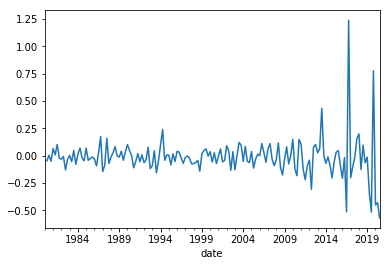

In [56]:
LongRatesQuarterYields = LongRates.resample('q').last().pct_change()
LongRatesQuarterYields['GBR'].plot()

In [57]:
BondReturnsPastQuarter = BondReturnIndex.resample('Q').last().pct_change()

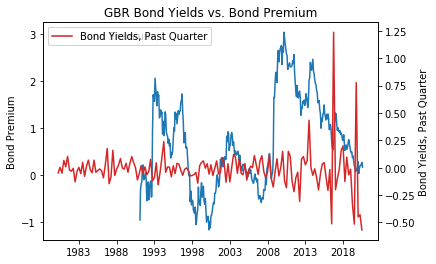

In [58]:

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Bond Premium'
ax1.plot(LongMinusShortRates['GBR'].to_timestamp(), color = 'tab:blue', label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend(loc=2)
ax2_label = 'Bond Yields, Past Quarter'
ax2.plot(LongRatesQuarterYields['GBR'].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title('GBR Bond Yields vs. Bond Premium')
plt.show()

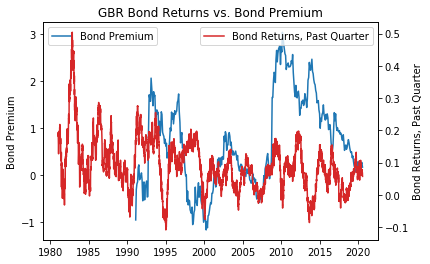

In [59]:
# Normally we expect greater returns if bond premiums are higher

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Bond Premium'
ax1.plot(LongMinusShortRates['GBR'].to_timestamp(), color = 'tab:blue', label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend(loc=2)
ax2_label = 'Bond Returns, Past Quarter'
ax2.plot(BondReturnMethod1.to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title('GBR Bond Returns vs. Bond Premium')
plt.show()



# Change In GDP 

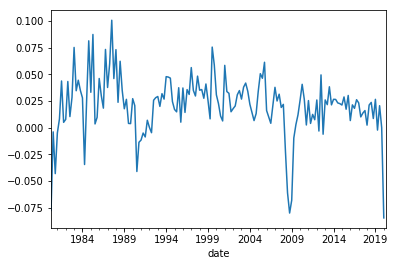

In [60]:
RGDP = dl.pull('GDP/Real')
RGDPChangeQoQ_Unannualized = RGDP.pct_change(1, fill_method = None).dropna(how='all')
RGDPChangeQoQ = (RGDPChangeQoQ_Unannualized + 1) ** 4 - 1
RGDPChangeQoQ['GBR'].plot()

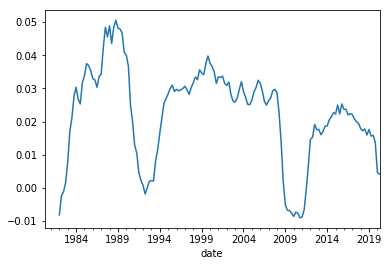

In [61]:
# Doing a rolling mean over three years 
RGDPChangeRollingMean = RGDPChangeQoQ['GBR'].rolling(12, min_periods=8).mean() 
RGDPChangeRollingMean.plot()

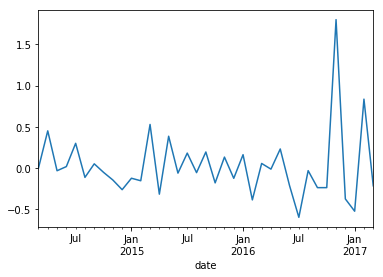

In [62]:
# If QoQ GDP growth is going well that means strong growth, Fed might raise interest rates 
# Short rates over a period
ShortRates['GBR'].pct_change().loc[pd.Period('2014-03'):pd.Period('2017-03')].plot()

In [63]:
ShortRates['GBR'].pct_change().tail()

date
2020-04    -0.562264
2020-05    -0.698276
2020-06    -1.028571
2020-07    61.000000
2020-08     0.193548
Freq: M, Name: GBR, dtype: float64

In [64]:
ShortRates['GBR'].tail()

date
2020-04    0.116
2020-05    0.035
2020-06   -0.001
2020-07   -0.062
2020-08   -0.074
Freq: M, Name: GBR, dtype: float64

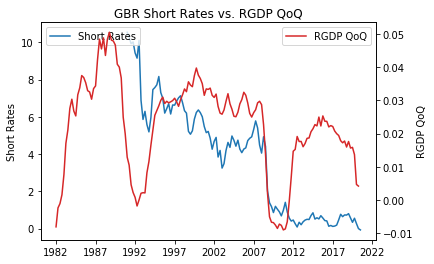

In [67]:
# Here I expect that if RGDPQoQ growth increases then short rates will follow because Central Bank will raise 
# interest rates in response to rising growth. Bond returns will go down. 

# When interest rates are increased, consumers tend to save as returns from savings are higher, inflation decreases. 

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Short Rates'
ax1.plot(ShortRates['GBR'].resample('Q').last().to_timestamp(), color = 'tab:blue', label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend(loc=2)
ax2_label = 'RGDP QoQ'
ax2.plot(RGDPChangeRollingMean.to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title('GBR Short Rates vs. RGDP QoQ')
plt.show()


This is interesting because we can see that short rates seem to follow RGDP QoQ growth. After the 2008 crisis interest rates did not recover to the same level.  

# Bond Returns vs. RGDP QoQ

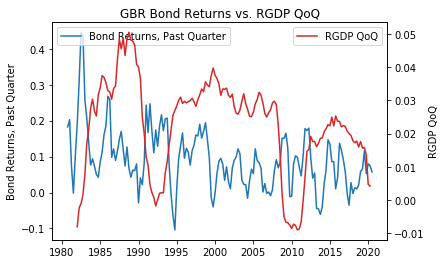

In [69]:
# As growth increases, bond returns go down. 

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Bond Returns, Past Quarter'
ax1.plot(BondReturnMethod1.resample('Q').last().to_timestamp(), color = 'tab:blue', label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend(loc=2)
ax2_label = 'RGDP QoQ'
ax2.plot(RGDPChangeRollingMean.to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title('GBR Bond Returns vs. RGDP QoQ')
plt.show()